In [22]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np
import pandas as pd
import sys

if '..' not in sys.path:
   sys.path.append('..')
from ehr2vec.time2event_tmle import simulation_r
from ehr2vec.time2event_tmle.simulation_r import simulate_data, theoretical_survival_function
import importlib
importlib.reload(simulation_r)

<module 'ehr2vec.time2event_tmle.simulation_r' from 'c:\\users\\fjn197\\phd\\projects\\phair\\pipelines\\ehr2vec_phair\\ehr2vec\\ehr2vec\\time2event_tmle\\simulation_r.py'>

c:\users\fjn197\phd\projects\phair\pipelines\ehr2vec_phair\ehr2vec\ehr2vec\time2event_tmle\simulation_r.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  survival_prob = np.exp(-rate[:, np.newaxis] * t / 2)


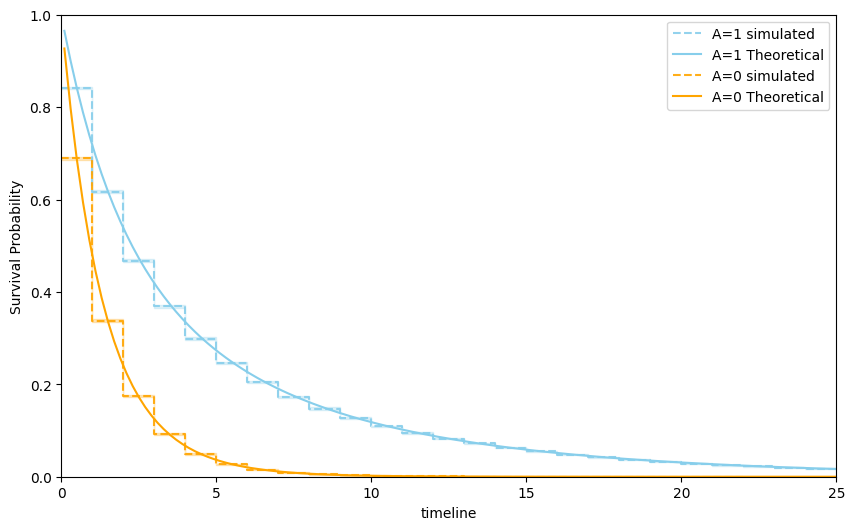

In [23]:
data = simulate_data(10000, )
data = pd.DataFrame(data)
time_points = np.linspace(.1, 40, 200)
survival_curve_treated = theoretical_survival_function(time_points, data['X'], 1)

# simulate all under treatment
data_treated = simulate_data(100000, A=1)
survival_curve_untreated = theoretical_survival_function(time_points, data_treated['X'], 0)
data_untreated = simulate_data(100000, A=0)

# make a Kaplan-Meier curve
fig, ax = plt.subplots(figsize=(10, 6))
# Treated
kmf = KaplanMeierFitter()
kmf.fit(data_treated['T_observed'], event_observed=data_treated['Y'], label='A=1 simulated')
kmf.plot(ax=ax, alpha=.9, linestyle='--', color='skyblue')
ax.plot(time_points, survival_curve_treated, label='A=1 Theoretical', color='skyblue')

# Untreated
kmf.fit(data_untreated['T_observed'], event_observed=data_untreated['Y'], label='A=0 simulated')
kmf.plot(ax=ax, alpha=.9, linestyle='--', color='orange')
ax.plot(time_points, survival_curve_untreated, label='A=0 Theoretical', color='orange')
ax.set_xlabel('timeline')
ax.set_ylabel('Survival Probability')
ax.set_xlim(0, 25)
ax.set_ylim(0, 1)
plt.legend()
plt.show()

## Estimate PS

In [32]:
from lifelines import KaplanMeierFitter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from lifelines import KaplanMeierFitter, CoxPHFitter
# Step 1: Fit the treatment model to estimate propensity scores
X = data['X'].values.reshape(-1, 1)
treatment_model = LogisticRegressionCV(cv=5).fit(X, data['A'])
data['propensity'] = treatment_model.predict_proba(X)[:, 1]

## Estimate survival function for failure event $S_E(t|A,X)$
It is defined as:  
&nbsp;&nbsp;$S_E(t|A,X)=\Pi_{k=1}^{t}[1-\lambda_E(k|A,X)]\,,$  
where $\lambda_N(t|A,X)$ is the hazard function for failure event $E$ at time $t$ given $A$ and $X$, which can be computed as:    
&nbsp;&nbsp;$\lambda_E(t|A,X)=P[E(t)=1|\,A,\,X]\,,$  

In practice we restructure the data, to be able to to train one classifier which takes $t-1$, $A$ and $X$ and predicts whether the event $N$ will occur at time $t$.  
What we do is we construct, for each t, until the event or censoring occurs, a row with the following columns:
- label $E(t)$ which is the event indicator
- X
- A
- t  

Here is an example dataset:  
- T_observed = {2, 3, 5}
- E = {0, 1, 0}
- A = {0, 1, 0}
- X = {1, 2, 3}  
  
From that we can construct the classification dataset as follows:  
for patient 1:
- $Y_E = \{0, 0, 0\}$
- t = {0, 1, 2}
- A = {0, 0, 0}
- X = {1, 1, 1}
  
for patient 2:
- $Y_E = \{0, 0, 0, 1\}$
- t = {0, 1, 2, 3}
- A = {1, 1, 1, 1}
- X = {2, 2, 2, 2} ...


In [96]:
def get_indicator(t, T_observed, Y, model_type):
    """Determine the event or censoring indicator based on model type."""
    if model_type == 'failure':
        return 1 if (t == T_observed and Y == 1) else 0
    elif model_type == 'censoring':
        return 1 if (t == T_observed and Y == 0) else 0
    else:
        raise ValueError("model_type must be either 'failure' or 'censoring'")

def transform_data_for_model_estimation(data, model_type='failure'):
    """Transform the data for either the failure model or the censoring model estimation.
    
    Args:
        data (pd.DataFrame): The input data containing T_observed, Y, A, X.
        model_type (str): Either 'failure' or 'censoring' to specify which model to transform the data for.
    
    Returns:
        pd.DataFrame: The transformed data suitable for classification.
    """
    expanded_rows = []

    # Loop over each patient in the original data
    for index, row in data.iterrows():
        T = int(row['T_observed'])
        expanded_rows.extend([
            {
                'pid': index,
                't': t,
                'A': row['A'],
                'X': row['X'],
                'Y_E': get_indicator(t, T, row['Y'], 'failure'),
                'Y_C': get_indicator(t, T, row['Y'], 'censoring')
            }
            for t in range(0, T + 1)
        ])

    # Create DataFrame from the list of rows
    expanded_data = pd.DataFrame(expanded_rows)
    return expanded_data

In [98]:
classification_data = transform_data_for_model_estimation(data)
# Step 2: Fit the failure model to estimate the survival curve
X = classification_data[['t', 'A', 'X']]
Y_E = classification_data['Y_E']
failure_model = GradientBoostingClassifier().fit(X, Y_E)

## Estimate censoring model $S_C(t|A,X)$   
Same as failure model but swap E and C.
Example with the previous data:
- T_observed = {2, 3, 5}
- E = {0, 1, 0}
- A = {0, 1, 0}
- X = {1, 2, 3}
for simpplicity we only write down the labels  
patient 1:
- $Y_C = \{0, 0, 1\}$  
patient 2:  
- $Y_C = \{0, 0, 0, 0\}$ (since event occurs)  
patient 3:
- $Y_C = \{0, 0, 0, 0, 0, 1\}$ 

In [110]:
Y_C = classification_data['Y_C']
censoring_model = GradientBoostingClassifier().fit(X, Y_C)

## IPCW  
The (plug-in) IPCW estimator of the survival function for the treated is defined as:  
&nbsp;&nbsp; $\hat{S}_{\text{IPCW}}(t) = \frac{1}{n}\sum_{i=1}^{n}\frac{I(\tilde{T}_{obs}>t,\,\Delta_i=1,\,A_i=1)}{S_C(\tilde{T}|X_i,\, A_i=1)g(X_i)}$  
sidenote: For each $t$, we sum over patients who are still at risk, but have the event observed at some time. 

In [100]:
classification_data

,pid,t,A,X,Y_E,Y_C
0,0,0,0,0.561810,0,0
1,0,1,0,0.561810,0,0
2,0,2,0,0.561810,1,0
3,1,0,1,1.426071,1,0
4,2,0,1,1.097991,0,0
...,...,...,...,...,...,...
37656,9997,0,1,1.420062,1,0
37657,9998,0,0,0.596232,0,0
37658,9998,1,0,0.596232,1,0
37659,9999,0,0,0.325711,0,0


In [ ]:
def estimate_censoring_probability(data, model):
    """Estimate the censoring probability using the censoring model.
    
    Args:
        data (pd.DataFrame): The input data containing T_observed, Y, A, X.
        model (object): The fitted censoring model.
    
    Returns:
        pd.DataFrame: The input data with an additional column 'censoring_probability'.
    """
    # for one patient, this would be
    pids_unique = data['pid'].unique()
    for pid in pids_unique:
        patient_data = data[data['pid'] == pid]
        X = patient_data[['t', 'A', 'X']]
        data.loc[data['pid'] == pid, 'censoring_probability'] = 1 - model.predict_proba(X)[:, 1]

In [113]:
for t_prime in range(1, 3):
    # 1. select patients with outcome but still at risk at time t
    # we need to check for each patient whether they have Y_E=1 at some point
    # and whether they are still at risk at time t
    positive_pids = classification_data[classification_data['Y_E'] == 1]['pid'].unique()
    positive_patients_at_risk_at_t_prime = classification_data[(classification_data['t'] < t_prime) & (classification_data['Y_E'] == 0) & (classification_data['pid'].isin(positive_pids))]
    # censoring_probability = failure_model.predict_proba(positive_patients_at_risk_at_t[['t', 'A', 'X']])[:, 1]
    print(positive_patients_at_risk_at_t_prime)

        pid  t  A         X  Y_E  Y_C
0         0  0  0  0.561810    0    0
4         2  0  1  1.097991    0    0
6         3  0  1  0.897988    0    0
10        4  0  0  0.234028    0    0
12        5  0  1  0.233992    0    0
...     ... .. ..       ...  ...  ...
37644  9994  0  1  0.186921    0    0
37648  9995  0  1  1.286484    0    0
37653  9996  0  1  1.346263    0    0
37657  9998  0  0  0.596232    0    0
37659  9999  0  0  0.325711    0    0

[7796 rows x 6 columns]
        pid  t  A         X  Y_E  Y_C
0         0  0  0  0.561810    0    0
1         0  1  0  0.561810    0    0
4         2  0  1  1.097991    0    0
6         3  0  1  0.897988    0    0
7         3  1  1  0.897988    0    0
...     ... .. ..       ...  ...  ...
37649  9995  1  1  1.286484    0    0
37653  9996  0  1  1.346263    0    0
37654  9996  1  1  1.346263    0    0
37657  9998  0  0  0.596232    0    0
37659  9999  0  0  0.325711    0    0

[12738 rows x 6 columns]


In [51]:
# Step 3: Compute the IPCW weights
data['weight'] = (data['A'] / data['propensity'] + (1 - data['A']) / (1 - data['propensity'])) / data['censoring_prob']

In [60]:
# Instantiate KaplanMeierFitter
kmf = KaplanMeierFitter()

# Fit the censoring model on the inverse of the event observed
kmf.fit(durations=data['T_observed'], event_observed=1 - data['Y'])

# Calculate the inverse probability of censoring weights
data['ipc_weights'] = 1 / kmf.survival_function_at_times(data['T_observed']).values


In [64]:
kmf.survival_function_at_times(data['T_observed']).values

array([0.99570364, 0.9994    , 0.99749662, ..., 0.9994    , 0.99749662,
       0.99749662])

In [61]:
data['ipc_weights']

0       1.004315
1       1.000600
2       1.002510
3       1.007668
4       1.002510
          ...   
9995    1.010295
9996    1.004315
9997    1.000600
9998    1.002510
9999    1.002510
Name: ipc_weights, Length: 10000, dtype: float64

In [52]:
data['weight']

0       [3.126713072327176, 5.121768191096048, 8.61462...
1       [1.4825720982955535, 2.6252878839423066, 4.793...
2       [1.4592355076371784, 2.1229797261507803, 3.151...
3       [1.5365582552209338, 2.053432634449635, 2.7871...
4       [1.9151482249466223, 2.647775326936501, 3.7247...
                              ...                        
9995    [1.4524347886353877, 2.3416523292721805, 3.873...
9996    [1.4617888930973129, 2.448306701115253, 4.2154...
9997    [1.4806761991747057, 2.6104350998797856, 4.744...
9998    [3.332914599504271, 5.582716772939849, 9.61325...
9999    [2.1509268465268527, 3.0966138425066623, 4.545...
Name: weight, Length: 10000, dtype: object

In [42]:
def plot_censoring(data, i):
    plt.plot(np.arange(len(data['censoring_prob'].iloc[i])), data['censoring_prob'].iloc[i])

In [58]:
data[data.Y==0]

,X,A,T,C,T_observed,Y,propensity,censoring_prob,weight,censoring_hazard
323,0.419901,0,4.0,3.0,3.0,0,0.490587,"[0.7966218097546814, 0.5280026896591364, 0.342...","[2.46421159184776, 3.717868746432926, 5.734305...",1.235484
402,0.757879,1,10.0,4.0,4.0,0,0.694084,"[0.8746737077630669, 0.6865254553287263, 0.531...","[1.647182698415728, 2.0986073961330263, 2.7086...",0.727593
519,0.225625,1,6.0,1.0,1.0,0,0.370461,"[0.934645534844078, 0.8270900733128073, 0.7271...","[2.888087640145274, 3.263656890824822, 3.71230...",0.367251
698,0.231544,1,33.0,14.0,14.0,0,0.373968,"[0.934163553673153, 0.8258926277058144, 0.7253...","[2.8624825066278854, 3.2377414944927163, 3.686...",0.370054
728,0.302441,0,8.0,6.0,6.0,0,0.416909,"[0.8223975723893534, 0.5774055254883238, 0.397...","[2.085365271946442, 2.9701817206259107, 4.3113...",1.062454
...,...,...,...,...,...,...,...,...,...,...
9435,0.444522,1,16.0,2.0,2.0,0,0.506193,"[0.9143579176800412, 0.7776476498775943, 0.655...","[2.1605683605010593, 2.5403957530432812, 3.013...",0.486495
9508,0.432318,1,28.0,27.0,27.0,0,0.498457,"[0.9156321718459404, 0.780695491197229, 0.6599...","[2.191044789025145, 2.5697485401257363, 3.0397...",0.478927
9792,0.022442,0,3.0,2.0,2.0,0,0.260108,"[0.8724387028953864, 0.6816095065229695, 0.525...","[1.5491611762608828, 1.982877518958709, 2.5718...",0.741495
9876,0.087252,0,3.0,1.0,1.0,0,0.292953,"[0.8621640190146375, 0.6593017493572798, 0.496...","[1.6404460655443198, 2.1451991811415683, 2.845...",0.805868


In [53]:
# Step 4: Fit the weighted Kaplan-Meier estimator to estimate the counterfactual survival curves
kmf_treated = KaplanMeierFitter()
kmf_treated.fit(data['T_observed'], event_observed=data['Y'], weights=data['weight'] * data['A'], label='A=1 Counterfactual')

kmf_untreated = KaplanMeierFitter()
kmf_untreated.fit(data['T_observed'], event_observed=data['Y'], weights=data['weight'] * (1 - data['A']), label='A=0 Counterfactual')

# Plot the survival curves
time_points = np.linspace(0, 30, 100)
survival_curve_treated = theoretical_survival_function(time_points, data['X'], np.ones_like(data['X']))
survival_curve_untreated = theoretical_survival_function(time_points, data['X'], np.zeros_like(data['X']))

ValueError: setting an array element with a sequence.